# PyTorch Deep Explainer Sample Example

A simple example showing how to explain an MNIST CNN trained using PyTorch with Deep Explainer.

In [191]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
# !pip install imblearn
import numpy as np
from model import FraudNet
from load_data import get_dataset, get_dataset_test
import shap
import pandas as pd
from sklearn.preprocessing import StandardScaler


from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

In [192]:
model = FraudNet(5)
print (model)

FraudNet(
  (embedding_layers): ModuleList(
    (0): Embedding(502, 10)
    (1): Embedding(266, 5)
    (2): Embedding(60, 3)
    (3): Embedding(61, 2)
    (4): Embedding(109, 3)
    (5): Embedding(11625, 20)
    (6): Embedding(4, 2)
    (7): Embedding(3, 2)
    (8): Embedding(106, 2)
    (9): Embedding(5, 2)
  )
  (fc1): Linear(in_features=91, out_features=45, bias=True)
  (fc2): Linear(in_features=45, out_features=22, bias=True)
  (fc3): Linear(in_features=22, out_features=11, bias=True)
  (fc4): Linear(in_features=11, out_features=5, bias=True)
  (fc5): Linear(in_features=5, out_features=1, bias=True)
)


In [193]:
# model.load_state_dict(torch.load('continuous_sameWt_eqSample_new_fc_0.3_2_0.333_0.333.th', map_location='cpu'))
model.load_state_dict(torch.load('best_model/smote_sameWt_categorical_fc_0.3_5_0.194_0.194.th', map_location='cpu'))
model = model.eval()

In [194]:
train_loader, valid_loader, test_loader, data = get_dataset(minibatch_size=64, device='cpu')

In [195]:
def preprocess(df):
    # x is pandas dataframe
    for i in range(1,11):
        # first 10 categorical variables
        k="C"+str(i)
        df[k].fillna(df[k].mode()[0], inplace=True) # fill with mode
        df[k] = df[k] - df[k].min()
    # fill with median in case of continuous
#     imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
    for i in range(1,41):
        k="V"+str(i)
        df[k] = pd.to_numeric(df[k], errors='coerce')
        df[k].fillna(df[k].median(), inplace=True)
    return df

test_data = pd.read_csv('./competition-data/competition-data/test.csv')
test_data = test_data.drop(columns='id')


In [196]:
X = preprocess(test_data).values
sc = StandardScaler()

# X = sc.fit_transform(X) # normalize numeric data
X[:, 10:] = sc.fit_transform(X[:, 10:]) # normalize numeric data
X = torch.from_numpy(X).to(device='cpu').float()
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=1)



In [197]:
# X_train, X_val, X_test, Y_train, Y_val, Y_test  = data

# background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
# background_embed = model.embedding_forward(background).detach().float()
# X_test_embed = model.embedding_forward(X_test).detach().float()

background = X[np.random.choice(X.shape[0], 100, replace=False)]
background_embed = model.embedding_forward(background).detach().float()
X_test_embed = model.embedding_forward(X).detach().float()

In [198]:
# base = np.array([11.0,265.0,1.0,0.0,4.0,190.0,2.0,2.0,0.0,0.0])   #train.csv
base = np.array([53.0, 10.0, 1.0, 0.0, 4.0, 190.0, 2.0, 2.0, 0.0, 0.0])   # test.csv
baseline = np.concatenate([base, np.zeros(40)])
baseline.shape

(50,)

In [199]:
model.continuous = False
expectedVal = model.forward(torch.Tensor(baseline[None, :])).detach().numpy()[0]
baseline_tensor = torch.Tensor(np.tile(baseline[None, :], [X.shape[0],1]))

baseline_embed = model.embedding_forward(baseline_tensor)


nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.


In [200]:
embeddingIdx = np.cumsum(model.embedding_output_sizes)
embeddingIdx = np.hstack((0, embeddingIdx))

def merge_categorical(shap_values):
    final_shap = []
    for i in range(len(embeddingIdx)-1):
        shapval = np.sum(shap_values[:, embeddingIdx[i]:embeddingIdx[i+1]], axis=1)[:, None]
        final_shap.append(shapval)
    final_shap.append(shap_values[:, embeddingIdx[-1]:])
    # for i in final_shap:
    #     print(i.shape)
    final_shap = np.concatenate(final_shap, axis=1)
    return final_shap

In [201]:
model.continuous = True

# Deep lift

In [210]:
dl = DeepLift(model)
attributions, delta = dl.attribute(X_test_embed, baseline_embed, target=0, return_convergence_delta=True)

In [211]:
deeplift_attributions = merge_categorical(attributions.detach().numpy())

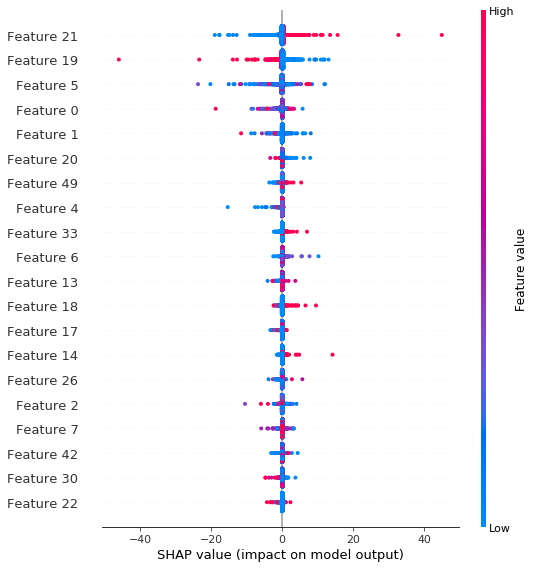

In [212]:
shap.summary_plot(deeplift_attributions, X)

In [213]:
# deeplift_attributions = np.absolute(attributions.detach().numpy())
# dft = deeplift_attributions - np.min(deeplift_attributions, axis=1)[:, None]
# dft[42,:]

In [214]:
# deeplift_attributions = np.absolute(deeplift_attributions)
# deeplift_attributions = deeplift_attributions - np.min(deeplift_attributions, axis=1)[:, None]
# np.where(deeplift_attributions.sum(axis=1)==0)

In [215]:
import pickle 

deeplift_attributions = np.absolute(deeplift_attributions)
deeplift_attributions = deeplift_attributions - np.min(deeplift_attributions, axis=1)[:, None]
deeplift_attributions = deeplift_attributions/(deeplift_attributions.sum(axis=1)[:, None]+1e-5)

db = {}
db['attributes'] = deeplift_attributions
dbfile = open('deeplift', 'ab') 
pickle.dump(db, dbfile)
dbfile.close()

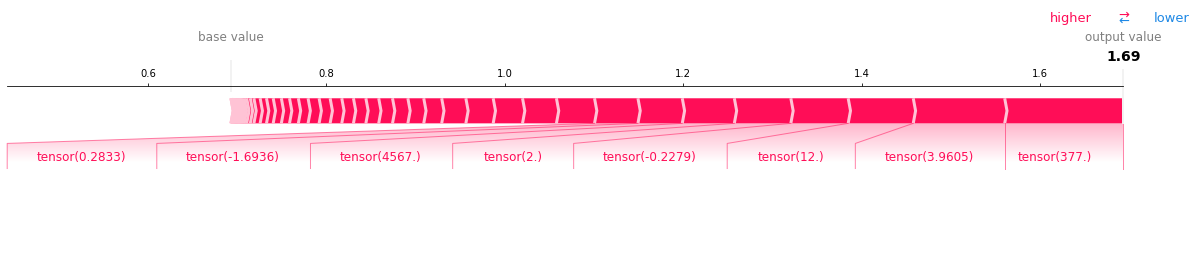

In [216]:
# might not be right (as expected val is not right)
shap.force_plot(expectedVal[0], deeplift_attributions[0,:], X[0,:], matplotlib=True)

In [217]:
e = shap.DeepExplainer(model, background_embed)
shap_values = e.shap_values(X_test_embed)

In [218]:
shap_attributions = merge_categorical(shap_values)

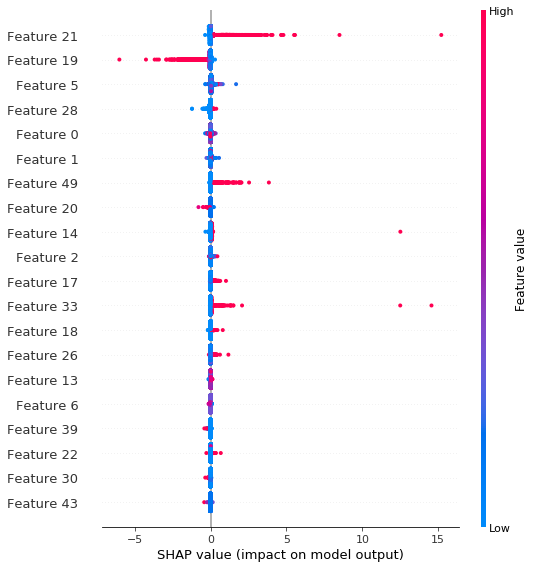

In [219]:
shap.summary_plot(shap_attributions, X)

In [220]:
import pickle 

shap_attributions = np.absolute(shap_attributions)
shap_attributions = shap_attributions - np.min(shap_attributions, axis=1)[:, None]
shap_attributions = shap_attributions/shap_attributions.sum(axis=1)[:, None]

db = {}
db['attributes'] = shap_attributions
dbfile = open('shap', 'ab') 
pickle.dump(db, dbfile)
dbfile.close()

(14516, 50)